### Task Selection (AstroVizBench)

[Link to ground truth task completion](#ground-truth-workflow-setup-processing-and-visualization)

In [70]:
import json

# Download JSON from here: https://utexas.app.box.com/s/2evj5cs3u2gqndvgc9sd66cmlggl9fg1/file/1863592775868
# Change the path to the downloaded file accordingly
with open('/Users/kahaan/Downloads/cmbagent/astrovisbench_queries.json', 'r') as f:
    queries = json.loads(f.read())  # List of dictionaries

for q in queries:
    if q['uid'] == 'dbaf0eac-4de5-4c4c-8721-13c9c4432cb8':  # Joint query task between photometric and spectroscopic catalogs
    # if q['uid'] == 'fff44712-f596-45c9-8932-0ba138cc12bf':  # Accessing DELVE DR1 catalog
    # if q['uid'] == '33295b64-6b01-4666-bc42-99f8bd05735c':
        query = q
        break

# query
# query.keys()

### Task Completion (cmbagent)

In [67]:
import os
import cmbagent
from PIL import Image
from google.genai import types
from google import genai

OAI_API_KEY    = os.getenv('OPENAI_API_KEY')
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

# Prompt from AstroVizBench
task = f"""
You are tasked with completing a Jupyter Notebook about astronomy. You will be given some Markdown cells
and some Python code cells for context, and in response you must output code that accurately
fulfills the goals of the notebook as described by the Markdown text.

Input:
Setup query: {query['setup_query']}
Ground truth setup code: {query['setup_gt_code']}
Processing query: {query['processing_query']}
Ground truth processing code: {query['processing_gt_code']}
Visualization query: {query['visualization_query']}
Visualization specifications: {query['visualization_underspecifications']}

Output:
Code generated for the visualization query.
"""
results = cmbagent.one_shot(task,
                   max_rounds=50,
                   agent='engineer',
                   # agent='researcher',
                   engineer_model='gemini-2.5-flash',
                   work_dir="/Users/kahaan/Downloads/cmbagent/output",
                  )


You are tasked with completing a Jupyter Notebook about astronomy. You will be given some Markdown cells
and some Python code cells for context, and in response you must output code that accurately
fulfills the goals of the notebook as described by the Markdown text.

Input:
Setup query: # Setup

Ensure you have all the necessary libraries and modules imported for astronomical data analysis and visualization. This includes libraries for plotting, data handling, and any necessary scientific computation utilities. Additionally, set up Notebook-specific configurations, such as initializing plotting modes for inline display, and establish any required authentication for accessing external astronomical data repositories. This setup will provide a solid foundation for query execution and visualization tasks related to astronomical datasets.

Ground truth setup code: # std lib
from getpass import getpass

# 3rd party
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import

### Simple VLM-as-a-judge

**Rationale:**

- **Appropriate Range and Rectangular Region**: The visualization displays RA from about 131° to 126° and Dec from 7° to 12°, which is a well-specified rectangular region, as required.
- **Overplotting and Marker Distinction**: The LS catalog sources are shown as larger red points, while SDSS sources are smaller black points, clearly distinguishing the two catalogs and enabling visual assessment of overlap and alignment.
- **Axis Labeling**: Both axes are labeled (“Right Ascension (deg)”, “Declination (deg)”) and the plot has an appropriate title and legend.
- **RA Orientation**: The RA axis is reversed (higher values to the left, lower to the right), as is standard in astronomical sky plots.
- **Visual Confirmation of Alignment**: Overplotting visually confirms the positional agreement between the two catalogs—this is evident as the red and black markers largely overlap, which is the expected result from crossmatching.

**Verdict:**  
No Error


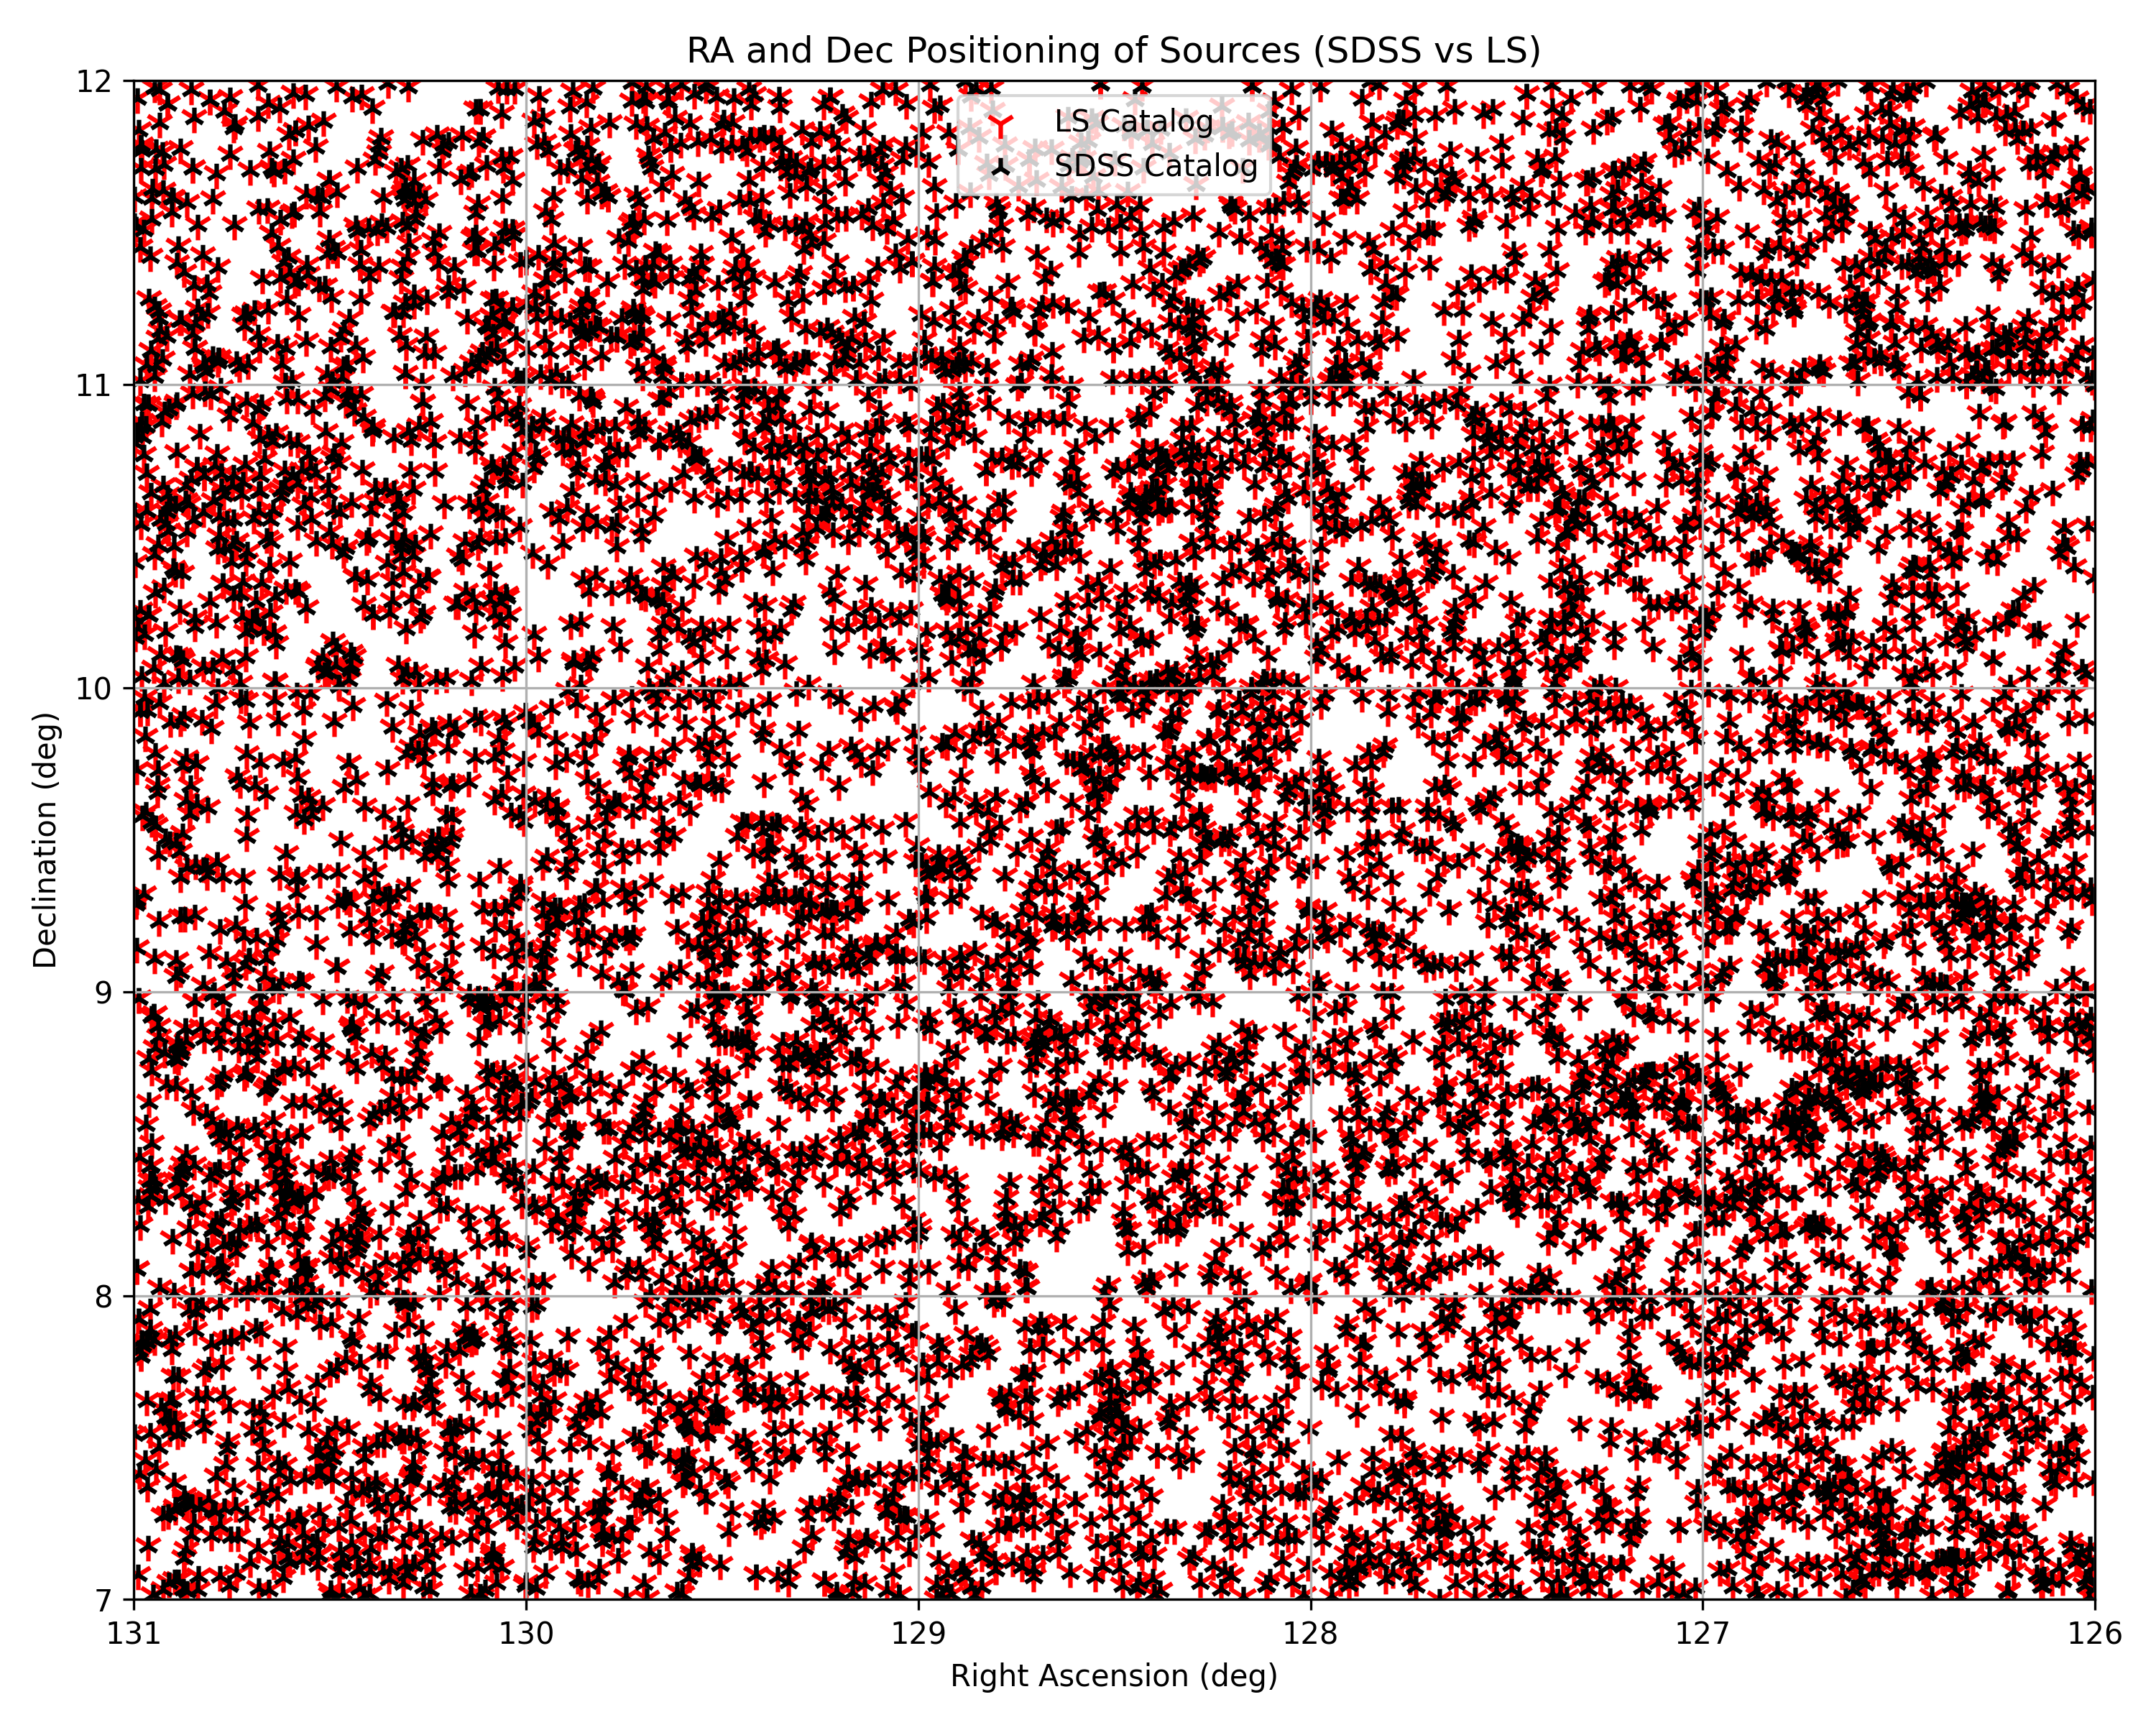

In [68]:
import base64
from openai import OpenAI

vlm_task = f"""
You are an expert astronomer. Your task is to evaluate the correctness and visual validity of 
the visualization that will be sent to you. You will first return your rationale, and then a
verdict of "No Error", "Minor Error", or "Major Error".
        
You will be given the visualization query that the visualization was created to fulfill.
Visualization query: {query['visualization_query']}.
"""

client = OpenAI()

def encode_image(img_path):
    with open(img_path, 'rb') as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Encode final plot from cmbagent output
final_img_path = results['final_context'].data['displayed_images'][-1]
base_64_img = encode_image(final_img_path)

completion = client.chat.completions.create(
    model='gpt-4.1',
    messages=[
        {
            'role': 'user',
            'content': [
                {'type': 'text', 'text': vlm_task},
                {
                    'type': 'image_url',
                    'image_url': {
                        'url': f'data:image/png;base64,{base_64_img}',
                        'detail': 'auto'  # Low saves tokens, high improves understanding
                    }
                }
            ]
        }
    ]
)

print(completion.choices[0].message.content)
Image.open(final_img_path)

In [69]:
final_img_path = results['final_context'].data['displayed_images'][-1]

with open(final_img_path, 'rb') as f:
    image_bytes = f.read()
    client = genai.Client(api_key=GEMINI_API_KEY)
    
    response = client.models.generate_content(
        model='gemini-2.5-flash',
        contents=[
            types.Part.from_bytes(
                data=image_bytes,
                mime_type='image/png',
            ),
        f"""
        You are an expert astronomer. Your task is to evaluate the correctness and visual validity of 
        the visualization that will be sent to you. You will first return your rationale, and then a
        verdict of "No Error", "Minor Error", or "Major Error".
        
        You will be given the visualization query that the visualization was created to fulfill.
        Visualization query: {query['visualization_query']}.
        """
        ]
    )

print(response.text)
# Image.open(final_img_path)

**Rationale:**

The visualization successfully fulfills the requirements of the query, effectively displaying the RA and Dec positioning of sources from both the LS and SDSS catalogs for visual accuracy verification.

1.  **Coordinate Data and Range:** The plot clearly displays Right Ascension (RA) on the x-axis and Declination (Dec) on the y-axis, both labeled in degrees. The coordinate range is set from approximately 126 to 131 degrees in RA and 7 to 12 degrees in Dec, which constitutes an appropriate and specific rectangular region for comparison.
2.  **Reversed RA Axis:** The Right Ascension axis runs from 131 on the left to 126 on the right, meaning the values are decreasing from left to right. This is indeed a "reversed RA" axis, which is a common astronomical convention to represent increasing RA (East to West) from right to left on a Cartesian plot, aligning with the "correct astronomical orientation" request.
3.  **Overplotting and Marker Styles:** The plot correctly utilizes 

### Ground Truth Workflow: Setup, Processing, and Visualization

[Link to task selection.](#task-selection-astrovizbench)

Running ground truth setup code.


Running ground truth processing code.

  SELECT L.ra, L.dec, L.type, L.sersic, L.g_r, L.r_z,
         S.z, S.ra as plug_ra, S.dec as plug_dec, S.class, S.veldisp, S.veldisperr 
  FROM ls_dr10.tractor AS L
  JOIN ls_dr10.x1p5__tractor__sdss_dr17__specobj AS X ON L.ls_id=X.id1 
  JOIN sdss_dr17.specobj AS S ON X.id2 = S.specobjid 
  WHERE L.ra BETWEEN 126 AND 131 AND L.dec BETWEEN 7.0 AND 12.0 AND (L.ra_ivar > 0) 
  LIMIT 100000
  
Running ground truth visualization code.


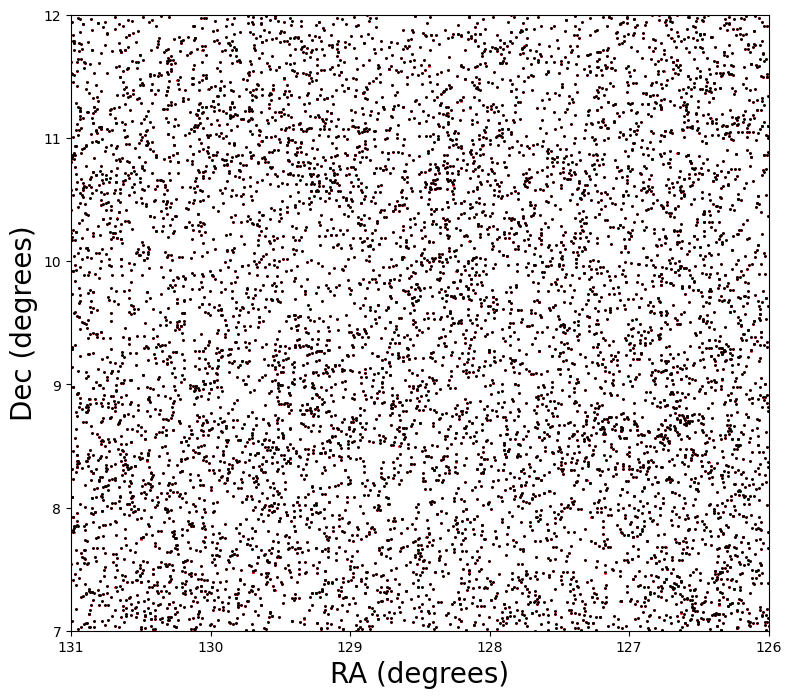

In [71]:
def clean_and_run(code_str):
    lines = code_str.splitlines()
    cleaned_lines = [line for line in lines if not line.strip().startswith('%')]
    cleaned_code = "\n".join(cleaned_lines)
    
    # Run the cleaned code
    exec(cleaned_code, globals())

setup_code         = query['setup_gt_code']
processing_code    = query['processing_gt_code']
visualization_code = query['visualization_gt_code']

print("Running ground truth setup code.")
clean_and_run(setup_code)
print("Running ground truth processing code.")
clean_and_run(processing_code)
print("Running ground truth visualization code.")
clean_and_run(visualization_code)